In [1]:
#!/usr/bin/python

import psycopg2
from config import config
from datetime import datetime, timedelta, date
import csv
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random


name2ID = {'Hawks': '1610612737','Celtics': '1610612738','Nets': '1610612751','Hornets': '1610612766','Bulls': '1610612741','Cavaliers': '1610612739','Mavericks': '1610612742','Nuggets': '1610612743','Pistons': '1610612765','Warriors': '1610612744','Rockets': '1610612745','Pacers': '1610612754','Clippers': '1610612746','Lakers': '1610612747','Grizzlies': '1610612763','Heat': '1610612748','Bucks': '1610612749','Timberwolves': '1610612750','Pelicans': '1610612740','Knicks': '1610612752','Thunder': '1610612760','Magic': '1610612753','76ers': '1610612755','Suns': '1610612756', 'Trailblazers': '1610612757', 'Trail Blazers': '1610612757','Kings': '1610612758','Spurs': '1610612759','Raptors': '1610612761','Jazz': '1610612762','Wizards': '1610612764'}
ID2name = {'1610612737':'Atlanta Hawks','1610612738':'Boston Celtics','1610612751':'Brooklyn Nets','1610612766':'Charlotte Hornets','1610612741':'Chicago Bulls','1610612739':'Cleveland Cavaliers','1610612742':'Dallas Mavericks','1610612743':'Denver Nuggets','1610612765':'Detroit Pistons','1610612744':'Golden State Warriors','1610612745':'Houston Rockets','1610612754':'Indiana Pacers','1610612746':'Los Angeles Clippers','1610612747':'Los Angeles Lakers','1610612763':'Memphis Grizzlies','1610612748':'Miami Heat','1610612749':'Milwaukee Bucks','1610612750':'Minnesota Timberwolves','1610612740':'New Orleans Pelicans','1610612752':'New York Knicks','1610612760':'Oklahoma City Thunder','1610612753':'Orlando Magic','1610612755':'Philadelphia 76ers','1610612756':'Phoenix Suns','1610612757':'Portland Trail Blazers','1610612758':'Sacramento Kings','1610612759':'San Antonio Spurs','1610612761':'Toronto Raptors','1610612762':'Utah Jazz','1610612764':'Washington Wizards'}
ID2PicName = {'1610612737':'Hawks','1610612738':'Celtics','1610612751':'Nets','1610612766':'Hornets','1610612741':'Bulls','1610612739':'Cavaliers','1610612742':'Mavericks','1610612743':'Nuggets','1610612765':'Pistons','1610612744':'Warriors','1610612745':'Rockets','1610612754':'Pacers','1610612746':'Clippers','1610612747':'Lakers','1610612763':'Grizzlies','1610612748':'Heat','1610612749':'Bucks','1610612750':'Timberwolves','1610612740':'Pelicans','1610612752':'Knicks','1610612760':'Thunder','1610612753':'Magic','1610612755':'76ers','1610612756':'Suns','1610612757':'Blazers','1610612758':'Kings','1610612759':'Spurs','1610612761':'Raptors','1610612762':'Jazz','1610612764':'Wizards'}
ID2longhashtag = {'1610612737':'atlantahawks','1610612738':'bostonceltics','1610612751':'brooklynnets','1610612766':'charlottehornets','1610612741':'chicagobulls','1610612739':'clevelandcavaliers','1610612742':'dallasmavericks','1610612743':'denvernuggets','1610612765':'detroitpistons','1610612744':'goldenstatewarriors','1610612745':'houstonrockets','1610612754':'indianapacers','1610612746':'losangelesclippers','1610612747':'losangeleslakers','1610612763':'memphisgrizzlies','1610612748':'miamiheat','1610612749':'milwaukeebucks','1610612750':'minnesotatimberwolves','1610612740':'neworleanspelicans','1610612752':'newyorkknicks','1610612760':'oklahomacitythunder','1610612753':'orlandomagic','1610612755':'philadelphia76ers','1610612756':'phoenixsuns','1610612757':'portlandtrailblazers','1610612758':'sacramentokings','1610612759':'sanantoniospurs','1610612761':'torontoraptors','1610612762':'utahjazz','1610612764':'washingtonwizards'}
ID2shorthashtag = {'1610612737':'hawks','1610612738':'celtics','1610612751':'nets','1610612766':'hornets','1610612741':'bulls','1610612739':'cavaliers','1610612742':'mavericks','1610612743':'nuggets','1610612765':'pistons','1610612744':'warriors','1610612745':'rockets','1610612754':'pacers','1610612746':'clippers','1610612747':'lakers','1610612763':'grizzlies','1610612748':'heat','1610612749':'bucks','1610612750':'timberwolves','1610612740':'pelicans','1610612752':'knicks','1610612760':'thunder','1610612753':'magic','1610612755':'76ers','1610612756':'suns','1610612757':'trailblazers','1610612758':'kings','1610612759':'spurs','1610612761':'raptors','1610612762':'jazz','1610612764':'wizards'}



Mon2MM = {'DEC':12, 'NOV':11, 'OCT': 10, 'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9}
ESPN2ID = {'Atlanta': '1610612737','Boston': '1610612738','Brooklyn': '1610612751','Charlotte': '1610612766','Chicago': '1610612741','Cleveland': '1610612739','Dallas': '1610612742','Denver': '1610612743','Detroit': '1610612765','Golden State': '1610612744','Houston': '1610612745','Indiana': '1610612754','LA': '1610612746','Los Angeles': '1610612747','Memphis': '1610612763','Miami': '1610612748','Milwaukee': '1610612749','Minnesota': '1610612750','New Orleans': '1610612740','New York': '1610612752','Oklahoma City': '1610612760','Orlando': '1610612753','Philadelphia': '1610612755','Phoenix': '1610612756','Portland': '1610612757','Sacramento': '1610612758','San Antonio': '1610612759','Toronto': '1610612761','Utah': '1610612762','Washington': '1610612764'}

In [2]:
def moneyLine2Prob(moneyLine):
	answer = 0
	mL = int(moneyLine)
	if mL > 0:
		answer = 100/ (100 + mL)
	else:
		mL = -1 * mL 
		answer = mL / (100 + mL)
	return answer

def prob2MoneyLine(impliedProb):
	answer = '100'
	if impliedProb == 1:
		impliedProb -= 0.01
	if impliedProb == 0:
		impliedProb+=0.01
	# print(impliedProb)
	if impliedProb > 0.5:
		answer = int(-100 * (impliedProb/(1-impliedProb)))
		answer = str(answer - (answer % 10))
	elif impliedProb < 0.5:
		answer = int(100* (1 - impliedProb)/impliedProb)
		answer = '+' + str(answer - (answer % 10)) # ((100 - probability)/(probability) * 100)
	
	return answer

In [3]:
#################################################################################################
## pulls current moneyLine from BetNow #####
#################################################################################################
def findCurrentMoneyLine():
	answer = []
	url = 'https://www.betnow.eu/sportsbook-info/basketball/nba'

	response = requests.get(url)
	html_soup = BeautifulSoup(response.text, 'html.parser')
	allTeams = html_soup.find_all('div', class_ = 'odd-info-teams')
	allOdds = html_soup.find_all('div', class_ = 'col-md-2 col-xs-3')
	teams = []
	odds = []
	for odd in allOdds:
		odds.append(odd.span.text[1:-1])
	for team in allTeams:
		teams.append(team.div.span.text[4:])
	for i in range(len(odds)):
		if len(odds[i]) > 2:
			currentRow = []
			currentRow.append(name2ID[teams[i]])
			currentRow.append(odds[i])
			answer.append(currentRow)
	return answer

def createTodayGames():
	answer = []
	url = 'https://www.espn.com/nba/schedule'
	response = requests.get(url)
	html_soup = BeautifulSoup(response.text, 'html.parser')
	upcomingDays = html_soup.find_all('table', class_ = 'schedule has-team-logos align-left')
	times = []
	for upcomingDay in upcomingDays:
		curTimes = upcomingDay.find_all('td', attrs = {'data-behavior':'date_time'})
		if len(curTimes) > 0:
			times = curTimes
			break
	teams = upcomingDay.find_all('a', class_ = 'team-name')

	allTeams = []
	allTimes = []

	for team in teams:
		curTeam = team.span.text
		allTeams.append(ESPN2ID[curTeam])
	for time in times:
		gameTime = time['data-date']
		allTimes.append(gameTime)
	for i in range(int(len(allTeams)/2)):
		currentRow = []
		currentRow.append(allTeams[(2*i)+1]) # home
		currentRow.append(allTeams[2*i]) # visitor
		answer.append(currentRow)

	return answer

In [4]:
predictionFile = "todayPreds.csv"
predFile = open(predictionFile, "r")
readerPred = csv.reader(predFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
todayGames = createTodayGames()
todayMoneyLines = findCurrentMoneyLine()
gameDict = {}
curRow = []
for row in readerPred:
	home_team = ''
	visit_team = ''
	home_current_ml = '-180'
	visit_current_ml = '+200'
	home_pct = float(row[1])
	visit_pct = 1.03 - home_pct

	home_ml = prob2MoneyLine(home_pct)
	visit_ml = prob2MoneyLine(visit_pct)
	homeIDcsv = str(row[0])
	gameVisitID = ""
	for game in todayGames:
		gameHomeID = game[0]
		if homeIDcsv == gameHomeID:
			# print(homeIDcsv)
			home_team = ID2name[gameHomeID]
			gameVisitID = game[1]
			visit_team = ID2name[gameVisitID]
	for moneyLine in todayMoneyLines:
		if moneyLine[0] == homeIDcsv:
			home_current_ml = moneyLine[1]
		elif moneyLine[0] == gameVisitID:
			visit_current_ml = moneyLine[1]

	home_current_pct = moneyLine2Prob(home_current_ml)
	visit_current_pct = moneyLine2Prob(visit_current_ml)
		
	gameDict[homeIDcsv] = {'home_id': homeIDcsv, 'visit_id': gameVisitID, 'home_team': home_team, 'visit_team': visit_team, 'home_pct': home_pct, 'visit_pct':visit_pct, 'home_current_pct':home_current_pct, 'visit_current_pct':visit_current_pct, 'home_ml':home_ml, 'visit_ml':visit_ml, 'home_current_ml':home_current_ml, 'visit_current_ml':visit_current_ml}
	
	curRow = [home_team, home_current_ml, home_ml, visit_team, visit_current_ml, visit_ml]

In [5]:
def makeCaption(game):
    captionOptions = ["Hammer the ", "Lock in the", "Send it on the ", "The ", "Roll with the "]
    captionChoice = random.choice(captionOptions)
    model_pct = game['home_pct']
    market_pct = game['home_current_pct']
    team = game['home_team']
    model_odds = game['home_ml']
    market_odds = game['home_current_ml']
    if market_pct < model_pct: 
        market_pct = game['visit_current_pct']
        model_pct = game['visit_pct']
        team = ['visit_team']
        model_odds = game['visit_ml']
        market_odds = game['visit_current_ml']
    pct = 100 * (model_pct - market_pct)
    caption = captionChoice + team + '.\n .\n .\n .\n' + 'The model predicts that they are ' + ("%.1f" % pct) + '% more likely to win than the market*' + '\n' + '\n' + '* At the time of calculation the market gave odds of ' + str(market_odds) + ' and NBANeural believes the odds should be ' + str(model_odds)
    return caption

In [6]:
def makeHashTags(game):
    home_team = ID2shorthashtag[game['home_id']]
#     long_home_team = ID2longhashtag[game['home_id']]
#     visit_team = ID2shorthashtag[game['visit_id']]
#     long_visit_team = ID2longhashtag[game['visit_id']]
    hashtags = "#" + home_team #+ " #"  + visit_team + " #"  + long_home_team + " #"  + long_visit_team 
    
    chooseFrom = ["nba", "moneyline", "nbalive", "instaball", "nbabasketball", "bball"]
    numChoices = 3
    choices = []
    while len(choices) < numChoices:
        curChoice = random.choice(chooseFrom)
        if curChoice not in choices:
            choices.append(curChoice)
    for i in range(numChoices):
        hashtags = hashtags + " #" + choices[i]
    return hashtags
    
    

In [7]:
def makeGraph(gameDict):
    postInfo = {}
    for home_team in gameDict:
        caption = makeCaption(gameDict[home_team])
        hashtags = makeHashTags(gameDict[home_team])
#         print(caption)
        curHomeID = gameDict[home_team]['home_id']
        fileName = "teamLogos/" + ID2PicName[curHomeID] + ".png"
        model_pct = gameDict[home_team]['home_pct']
        market_pct = gameDict[home_team]['home_current_pct']
        if market_pct > model_pct: 
            market_pct = gameDict[home_team]['visit_current_pct']
            model_pct = gameDict[home_team]['visit_pct']
        
        
        # Pie chart
        labels = ['Market % Lose', 'NN Insight',  'Market % Win']
        sizes = [int(100* (1 - model_pct)), int(100*(model_pct - market_pct)),int(100* market_pct)]
        #colors
        colors = ['#000000','#ef7b0a','#cccccc']
        
#         plt.figure(figsize=[5,5])

        fig, ax = plt.subplots()
        im = plt.imread(fileName)
        
        patch = patches.Circle((0, 0), color= '#000000',radius=0.8, transform=ax.transData)
        ax.pie(sizes, colors = colors, startangle=90)
        
        ax.add_patch(patch)
        imagebox = OffsetImage(im, zoom=.8, clip_path=patch, zorder=-10)
        ab = AnnotationBbox(imagebox, (0,0), xycoords='data', pad=0, frameon=False)
        ax.add_artist(ab)
        
        fig = plt.gcf()
        fig.gca().add_patch(patch)
        ax.add_patch(patch)
        

        # Equal aspect ratio ensures that pie is drawn as a circle
        ax.axis('off')  
#         plt.tight_layout()
        imageFile = 'home_' + str(curHomeID) + '.png'
        plt.savefig(imageFile)
#         plt.show()
        postInfo[curHomeID] = [imageFile, caption, hashtags]
    return postInfo


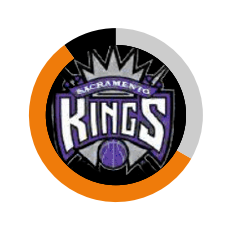

In [8]:
postInfo = makeGraph(gameDict)
# print(postInfo)

In [9]:
from PIL import Image

for post in postInfo:
    pngName = postInfo[post][0]
    jpgName = pngName[:-4] + ".jpg"
    im1 = Image.open(pngName)
    rgb_im = im1.convert('RGB')
    rgb_im.save(jpgName)
    postInfo[post][0] = jpgName

In [10]:
from instabot import Bot 

In [12]:
bot = Bot() 
# bot.logout()
bot.login(username = "nbaneural", password = "bombstackboomer") 
##### no hashtags #####
for post in postInfo:
    bot.upload_photo(postInfo[post][0], 
            caption = postInfo[post][1]) 
#############################################
##### hashtags #########################
# for post in postInfo:
#     bot.upload_photo(postInfo[post][0], 
#             caption = postInfo[post][1] + '\n' + postInfo[post][2])

2021-02-04 17:10:49,727 - INFO - Instabot version: 0.117.0 Started
2021-02-04 17:10:49,727 - INFO - Instabot version: 0.117.0 Started
2021-02-04 17:10:49,736 - INFO - Not yet logged in starting: PRE-LOGIN FLOW!
2021-02-04 17:10:49,736 - INFO - Not yet logged in starting: PRE-LOGIN FLOW!
2021-02-04 17:10:52,965 - INFO - Logged-in successfully as 'nbaneural'!
2021-02-04 17:10:52,965 - INFO - Logged-in successfully as 'nbaneural'!
2021-02-04 17:10:52,968 - INFO - LOGIN FLOW! Just logged-in: True
2021-02-04 17:10:52,968 - INFO - LOGIN FLOW! Just logged-in: True


home_1610612758.jpg
FOUND: w:432 h:288 r:1.5


2021-02-04 17:11:26,583 - INFO - Photo 'home_1610612758.jpg' is uploaded.
2021-02-04 17:11:26,583 - INFO - Photo 'home_1610612758.jpg' is uploaded.
